<a href="https://colab.research.google.com/github/Jadrianp29/testreko/blob/main/DS_C7_SC1_JesusAdrianAguilarPerez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reto | Predicción de Contingencias Ambientales en el Área Metropolitana de la Ciudad de Monterrey
Introducción

Una contingencia ambiental se presenta cuando un contaminante de la atmósfera rebasa los límites establecidos por las normas de calidad del aire vigentes. En diversos países existen contingencias ambientales, el área metropolitana de la ciudad de Monterrey en México es muy frecuente.

Las condiciones del clima como presión, temperatura, humedad relativa, luz solar, velocidad y dirección del viento, etc. afectan la concentración de contaminantes.



Existe la propuesta de implementar un programa de verificación vehicular. Se pretende investigar si la contaminación está ligada al tráfico usando la hora del día cómo representante del mismo.



Objetivo

Con el desarrollo del reto integrarás todos los conocimientos adquiridos, cumpliendo los siguientes objetivos:

Descubrir relaciones entre las variables dependientes e independientes para crear modelos predictivos usando correlación.
Aplicar modelos predictivos de machine learning y evalúa los resultados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, unix_timestamp
from pyspark.mllib.stat import Statistics
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator





In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path="/content/drive/MyDrive/Data scientist/MonterreyPollutionData.csv"

a)	En algún entorno Spark, carga los datos y elimina las variables innecesarias.

In [4]:
spark = SparkSession.builder.appName("MonterreyPollutionData").getOrCreate()
df_polution=spark.read.csv(path,header=True,inferSchema=True)

In [5]:
df_polution.show()

+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|01-ene-15|    1|  1|    jue|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.0

In [6]:
df_polution = df_polution.drop('Date','Month', 'Day', 'DayWeek', 'Weekday')
df_polution = df_polution.withColumnRenamed("PM2.5", "PM2_5")

In [7]:
df_polution.show()

+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2_5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.052|4.13|4.2| 15|
|  12|2.38|10.0|10.1|20.1| 10|  22|   17|722.6|  0.0| 96|0.127| 6.6|3.2| 29|
|  13|2.51|11.5|12.3|23.8| 12|  32|   16|721.7|  0.0| 95| 0.15|6.89|4.8|  2|
|  14|2.55|12.0|13.5|25.5| 14|  31|   19|721.0|  0.0| 94|0.175|7.43|4.6| 47|
|  15|2.45|10.5|12.8|23.3| 11|  50|   35|720.8|  0.0| 93|0.091|7.15|4.0| 42|

In [8]:
df_polution.columns

['Hour',
 'CO',
 'NO',
 'NO2',
 'NOX',
 'O3',
 'PM10',
 'PM2_5',
 'PRS',
 'RAINF',
 'RH',
 'SR',
 'TOUT',
 'WSR',
 'WDV']

b)	Realiza un análisis de correlación y establece qué variables ambientales o de tiempo afectan la concentración de contaminantes O3 y PM2.5. Algunas correlaciones son negativas. Toma en cuenta que algunas correlaciones son positivas y algunas negativas indicando que los contaminantes incrementan y otras bajan.

In [9]:
df_dropped = df_polution.na.drop()
df_dropped = df_dropped.drop("number")
df_columns2 = df_dropped.columns

In [10]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_dropped.columns, outputCol=vector_col)
df_vector = assembler.transform(df_dropped).select(vector_col)
column_names = assembler.getInputCols()

In [11]:
r1=Correlation.corr(df_vector,vector_col)
matrix = r1.collect()[0]["pearson({})".format(vector_col)].values


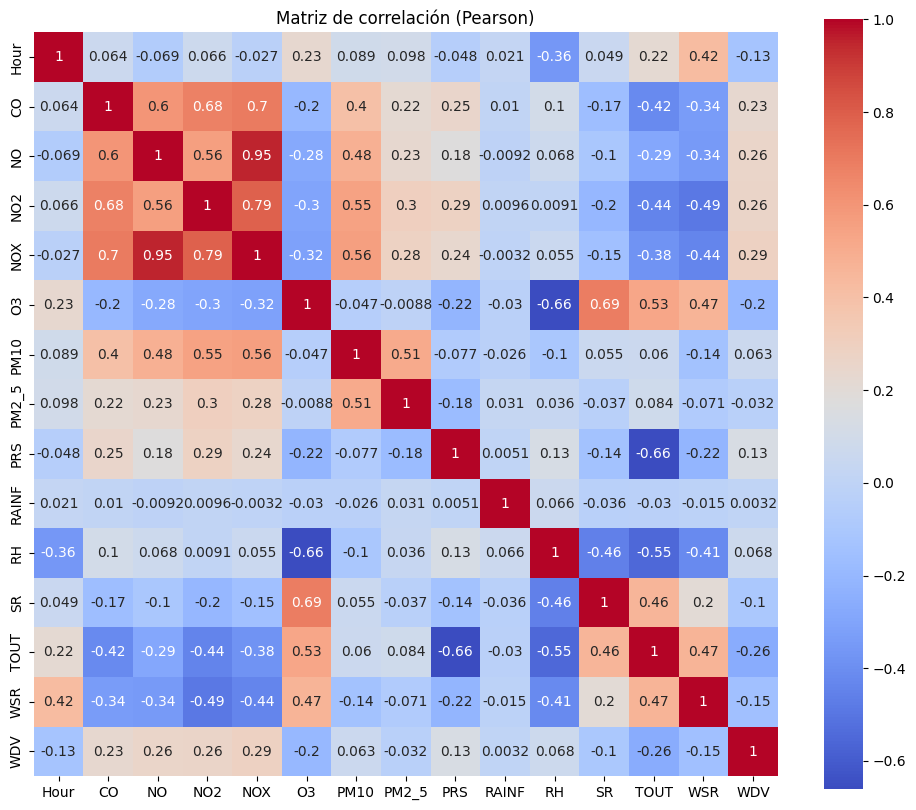

In [12]:
column_names = assembler.getInputCols()
num_vars = len(column_names)
corr_matrix = np.array(matrix).reshape(num_vars, num_vars)
df_corr = pd.DataFrame(corr_matrix, columns=column_names, index=column_names)
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', square=True)
plt.title("Matriz de correlación (Pearson)")
plt.show()

La Variable RH (humedad relativa) Afecta negativamente al Ozono (O3) en -.66. por lo que a mayor humedad menor Ozono
La Radiacion Solar (SR) afecta positivamente en .69 por lo que a mayor radiacion mayor Ozono
Las particulas Pm2_5 solo se ven afectadas positivamente por las particulas PM10

c)	Confirma estas relaciones usando gráficos de dispersión.

In [13]:
df_nona = df_polution.na.drop()
df_03=df_nona.select("O3")
df_03.show()
df_RH=df_nona.select("RH")
df_SR=df_nona.select("SR")
df_PM10=df_nona.select("PM10")
df_PM2_5=df_nona.select("PM2_5")
print(df_03.count(),df_RH.count())

+---+
| O3|
+---+
| 10|
|  7|
|  7|
|  7|
|  5|
|  7|
| 10|
| 12|
| 14|
| 11|
| 11|
| 10|
|  8|
|  6|
|  5|
|  5|
|  6|
|  6|
|  5|
|  6|
+---+
only showing top 20 rows

3859 3859


In [14]:
df_03_1 = df_03.rdd.map(lambda row : row.O3)
df_RH_1 = df_RH.rdd.map(lambda row : row.RH)
df_SR_1 = df_SR.rdd.map(lambda row : row.SR)
df_PM10_1 = df_PM10.rdd.map(lambda row : row.PM10)
df_PM2_5_1 = df_PM2_5.rdd.map(lambda row : row.PM2_5)


In [15]:
arr_03=df_03.collect()
arr_Rh= df_RH_1.collect()
arr_SR= df_SR_1.collect()
arr_PM10= df_PM10_1.collect()
arr_PM2_5= df_PM2_5_1.collect()

Relacion Ozono Humedad

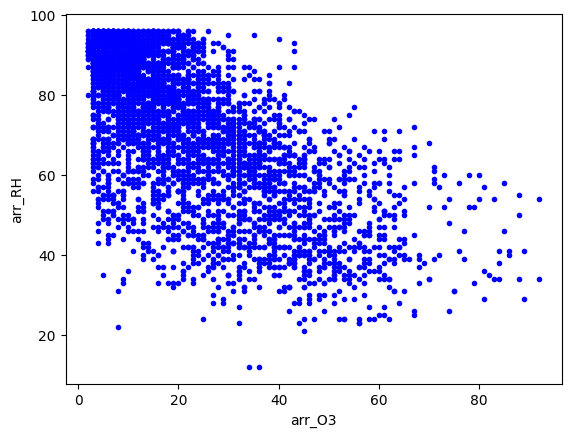

In [16]:
plt.plot(arr_03,arr_Rh,'b.')
plt.xlabel("arr_O3")
plt.ylabel("arr_RH")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

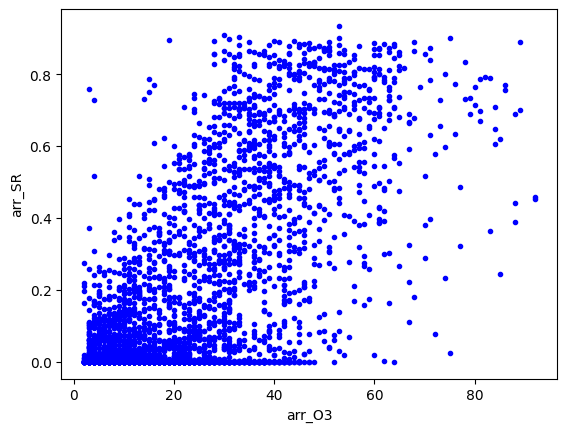

In [17]:
plt.plot(arr_03,arr_SR,'b.')
plt.xlabel("arr_O3")
plt.ylabel("arr_SR")
plt.show

Relacion Pm10 y Pm2.5

<function matplotlib.pyplot.show(close=None, block=None)>

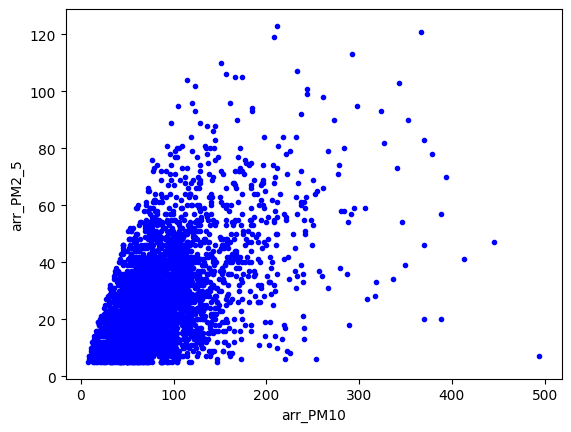

In [18]:
plt.plot(arr_PM10,arr_PM2_5,'b.')
plt.xlabel("arr_PM10")
plt.ylabel("arr_PM2_5")
plt.show

Crea modelos de regresión para predecir estos contaminantes con la menor cantidad de variables atributos posible. Puedes utilizar cualquier técnica: regresión lineal (o polinomial) multivariable, random forrests, gradient boost, o cualquier otra técnica que hayas investigado que funcione en Spark.

In [19]:
assembler = VectorAssembler(inputCols=['Hour','CO','NO','NO2','NOX','PM10','PRS','RAINF','RH','SR','TOUT','WSR','WDV'],outputCol='Attributes')

output = assembler.transform(df_polution)

#Input vs Output
finalized_data = output.select("Attributes","O3",'PM2_5')
finalized_data.show(10)

+--------------------+---+-----+
|          Attributes| O3|PM2_5|
+--------------------+---+-----+
|[1.0,2.51,10.2,12...| 10|   80|
|[2.0,2.41,9.2,11....|  7|   29|
|[3.0,2.39,8.1,11....|  7|    9|
|[5.0,2.26,5.3,8.9...|  7|   14|
|[8.0,2.25,7.2,10....|  5|    8|
|[9.0,2.21,5.8,8.2...|  7|    6|
|[12.0,2.38,10.0,1...| 10|   17|
|[13.0,2.51,11.5,1...| 12|   16|
|[14.0,2.55,12.0,1...| 14|   19|
|[15.0,2.45,10.5,1...| 11|   35|
+--------------------+---+-----+
only showing top 10 rows



In [20]:
train_data,test_data = finalized_data.randomSplit([0.8,0.2])

In [21]:
regressor = LinearRegression(featuresCol = 'Attributes', labelCol = 'O3')
regressor = regressor.fit(train_data)
print("The coefficient of the model is: %a" %regressor.coefficients)
print("The Intercept of the model is: %f" %regressor.intercept)


The coefficient of the model is: DenseVector([-0.0282, 3.2106, -9.7692, -9.9452, 9.6712, 0.008, -0.5093, 3.9459, -0.4234, 29.1172, -0.2968, 0.5379, -0.0134])
The Intercept of the model is: 418.912691


In [22]:
Pred_lr = regressor.evaluate(test_data)
Pred_lr.predictions.show(10)

+--------------------+---+-----+------------------+
|          Attributes| O3|PM2_5|        prediction|
+--------------------+---+-----+------------------+
|[0.0,0.55,2.9,5.5...| 17|   16|22.355835336523228|
|[0.0,0.57,2.4,4.2...| 31|   22| 20.83770712743177|
|[0.0,0.75,2.6,5.4...| 16|   23|11.254652355038218|
|[0.0,0.77,2.9,3.9...| 22|   22|24.046790469190967|
|[0.0,0.83,2.7,3.9...| 20|   11| 11.39417811729993|
|[0.0,0.83,3.2,5.4...| 14|   20|15.628866525093486|
|[0.0,0.83,3.4,26....| 20|    5| 21.41475499256751|
|[0.0,0.87,2.9,6.7...| 33|    8|21.752355197615543|
|[0.0,0.91,4.2,8.3...|  8|   16| 13.90455073093068|
|[0.0,1.03,3.0,5.5...| 18|   30|18.829890008733116|
+--------------------+---+-----+------------------+
only showing top 10 rows



In [26]:
eval_lr=RegressionEvaluator(labelCol="O3",predictionCol="prediction",metricName="rmse")

print("Linear regression model\n")

# Root Mean Square Error
rmse = eval_lr.evaluate(Pred_lr.predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "r2"})
print("r2: %.3f" %r2)

Linear regression model

RMSE: 8.602
MSE: 73.994
MAE: 6.337
r2: 0.723


In [23]:
gbt = GBTRegressor(featuresCol = 'Attributes', labelCol = 'O3')
gbt = gbt.fit(train_data)
predgbt = gbt.transform(test_data)
predgbt.select('prediction', 'O3', 'Attributes').show(5)

+------------------+---+--------------------+
|        prediction| O3|          Attributes|
+------------------+---+--------------------+
|30.286536845529028| 17|[0.0,0.55,2.9,5.5...|
| 19.12164576294048| 31|[0.0,0.57,2.4,4.2...|
| 17.12829165851178| 16|[0.0,0.75,2.6,5.4...|
|34.226509995351094| 22|[0.0,0.77,2.9,3.9...|
| 19.37456937808664| 20|[0.0,0.83,2.7,3.9...|
+------------------+---+--------------------+
only showing top 5 rows



In [29]:
eval_gbt=RegressionEvaluator(labelCol="O3",predictionCol="prediction",metricName="rmse")

print("Gbt\n")

# Root Mean Square Error
rmse = eval_gbt.evaluate(predgbt)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval_gbt.evaluate(predgbt, {eval_gbt.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval_gbt.evaluate(predgbt, {eval_gbt.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval_gbt.evaluate(predgbt, {eval_gbt.metricName: "r2"})
print("r2: %.3f" %r2)

Linear regression model

RMSE: 21.610
MSE: 467.004
MAE: 16.898
r2: -0.746


In [31]:
gbt2 = GBTRegressor(featuresCol = 'Attributes', labelCol = 'PM2_5')
gbt2 = gbt2.fit(train_data)
predgbt2 = gbt2.transform(test_data)
predgbt2.select('prediction', 'PM2_5', 'Attributes').show(5)

+------------------+-----+--------------------+
|        prediction|PM2_5|          Attributes|
+------------------+-----+--------------------+
| 21.55422179054768|   16|[0.0,0.55,2.9,5.5...|
|24.624215579954143|   22|[0.0,0.57,2.4,4.2...|
|18.265426472901776|   23|[0.0,0.75,2.6,5.4...|
|18.426329332055953|   22|[0.0,0.77,2.9,3.9...|
|13.875006567290567|   11|[0.0,0.83,2.7,3.9...|
+------------------+-----+--------------------+
only showing top 5 rows



In [32]:
eval_gbt2=RegressionEvaluator(labelCol="PM2_5",predictionCol="prediction",metricName="rmse")

print("GBT\n")

# Root Mean Square Error
rmse = eval_gbt2.evaluate(predgbt2)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval_gbt2.evaluate(predgbt2, {eval_gbt2.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval_gbt2.evaluate(predgbt2, {eval_gbt2.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval_gbt2.evaluate(predgbt2, {eval_gbt2.metricName: "r2"})
print("r2: %.3f" %r2)

GBT

RMSE: 13.555
MSE: 183.740
MAE: 10.202
r2: 0.365


El mejor modelo para predecir los valores futuros es el modelo lineal ya que obtiene un R2 de .72 positivo , mientras que el modelo GBT muestra un R2 negativo.
De manera similar el error cuadrado medio es menor en el modelo lineal.
